# Exercise: Nonlinear Programming¶

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from casadi import (
    DM, MX, Function, 
    vertcat, horzcat,
    gradient, hessian, jacobian,
    inf, tanh, sin, cos,
    conic, rootfinder
)


import casadi
casadi.__version__

'3.6.4'

In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Problem

$$
\begin{aligned}
\min_x & \quad & x_1^2 + \tanh(x_2)^2 \\
\text{subject to} & \quad & \cos(x_1 + x_2) = 0 \\
                  & \quad & \sin(x_1) + 0.5 \le 0 \\
\end{aligned}
$$

with $x \in \mathbb{R}^2$.

In [3]:
x1 = 0.
x2 = np.arccos(-0.5) - x1
x2

2.0943951023931957

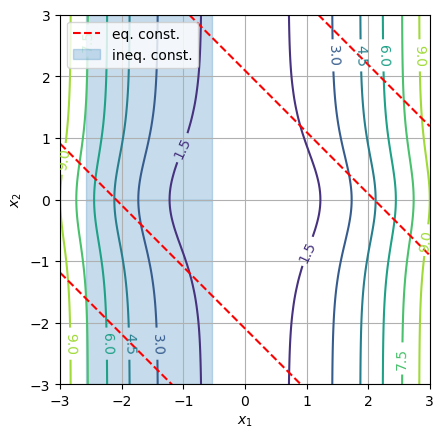

In [4]:
def plot_countours(x1_lim=(-3, 3), x2_lim=(-3, 3)):
    x1_range = np.linspace(x1_lim[0], x1_lim[1], 101)
    x2_range = np.linspace(x2_lim[0], x2_lim[1], 101)
    x1, x2 = np.meshgrid(x1_range, x2_range)
    f = x1**2 + tanh(x2) ** 2
    x2_eq_consts1 = [np.arccos(-0.5) - x1_range + i*2*np.pi for i in range(-1, 2)]
    x2_eq_consts2 = [-np.arccos(-0.5) - x1_range + i*2*np.pi for i in range(-1, 2)]
    x1_ineq_const = np.sin(x1_range) <= -0.5
    fill_areas_pos = np.where(x1_ineq_const, x2_lim[1], np.nan)
    fill_areas_neg = np.where(x1_ineq_const, x2_lim[0], np.nan)

    fig, ax = plt.subplots()
    cs = ax.contour(x1, x2, f)
    ax.clabel(cs, inline=1, fontsize=10)
    label = 'eq. const.'
    for x2_1, x2_2 in zip(x2_eq_consts1, x2_eq_consts2):
        ax.plot(x1_range, x2_1, linestyle='--', color='r', label=label)
        label = None
        ax.plot(x1_range, x2_2, linestyle='--', color='r')
    ax.fill_between(x1_range, fill_areas_pos, alpha=0.25, color='tab:blue', label='ineq. const.')
    ax.fill_between(x1_range, fill_areas_neg, alpha=0.25, color='tab:blue')
    ax.set_xlim(x1_range[[0, -1]])
    ax.set_ylim(x2_range[[0, -1]])
    ax.set_aspect('equal')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(loc='upper left')
    ax.grid()

    return ax

plot_countours()
filename = 'nlp_contour_plot'
plt.savefig(os.path.join(plot_dir, filename + '.pdf'))
plt.savefig(os.path.join(plot_dir, filename + '.png'), dpi=150)
plt.show()

## Duality

From [wikipedia.org](https://en.wikipedia.org/wiki/Duality_(optimization)):

 - In mathematical optimization theory, **duality** or the **duality principle** is the principle that optimization problems may be viewed from either of two perspectives, the **primal problem** or the **dual problem**. If the primal is a minimization problem then the dual is a maximization problem (and vice versa).
 - In general, the optimal values of the primal and dual problems need not be equal. Their difference is called the **duality gap**. For convex optimization problems, the duality gap is zero under a constraint qualification condition. This fact is called **strong duality**.
 - The Lagrangian dual problem is obtained by forming the [**Lagrangian**](https://en.wikipedia.org/wiki/Lagrange_multiplier) of a minimization problem by using nonnegative **Lagrange multipliers** to add the constraints to the objective function, and then solving for the primal variable values that minimize the original objective function. This solution gives the primal variables as functions of the Lagrange multipliers, which are called dual variables, so that the new problem is to maximize the objective function with respect to the dual variables under the derived constraints on the dual variables (including at least the nonnegativity constraints).

## 2. Sequential Quadratic Programming (SQP) Method

$$
\begin{aligned}
\min_x & \quad & f(x) \\
\text{subject to} & \quad & g(x) = 0, \\
                  & \quad & h(x) \le 0. \\
\end{aligned}
$$

### 1.1. Decision variables and expressions for f, g, h

In [5]:
x = MX.sym('x', 2)
x.shape

(2, 1)

In [6]:
f = x[0]**2 + tanh(x[1]) ** 2
f

MX((sq(x[0])+sq(tanh(x[1]))))

In [7]:
g = cos(x[0] + x[1]) + 0.5
g

MX((0.5+cos((x[0]+x[1]))))

In [8]:
h = sin(x[0]) + 0.5
h

MX((0.5+sin(x[0])))

### 1.2. Symbolic expression for the Lagrangian

$$ \mathcal{L}(x, \lambda, \nu) = f(x) + \lambda * g(x) + \nu * h(x) $$

In [9]:
lam = MX.sym('λ')  # Lagrangian multiplier
nu = MX.sym('ν')  # multiplier for the inequalities
lagrangian_expr = f + lam * g + nu * h
lagrangian_expr

MX((((sq(x[0])+sq(tanh(x[1])))+(λ*(0.5+cos((x[0]+x[1])))))+(ν*(0.5+sin(x[0])))))

In [10]:
lagrangian_func = Function('lag', [x, lam, nu], [lagrangian_expr])
lagrangian_func

Function(lag:(i0[2],i1,i2)->(o0) MXFunction)

In [11]:
lag = lagrangian_func(vertcat(-0.5, -1.8), 2, 3)
lag

DM(0.875613)

In [12]:
assert abs(lag - 0.875613) < 1e-6

### 1.3. QP approximation

QP approximation at interation $k$:

$$
\begin{aligned}
\min_{\Delta x_k} & \quad & f_k 
    + \frac{\partial f_k}{\partial x} \Delta x_k 
    + \frac{1}{2} \Delta x_k^T \frac{\partial^2 \mathcal{L}_k}{\partial x^2} \Delta x_k \\
\text{subject to} & \quad & g_k + \frac{\partial g_k}{\partial x} \Delta x_k = 0, \\
                  & \quad & h_k + \frac{\partial h_k}{\partial x} \Delta x_k  \le 0. \\
\end{aligned}
$$

In [13]:
df_dx = jacobian(f, x)
df_dx.shape

(1, 2)

In [14]:
d2lag_dx2 = hessian(lagrangian_expr, x)[0]
d2lag_dx2.shape

(2, 2)

In [15]:
dx = MX.sym('Δx', 2)
dx.shape

(2, 1)

In [16]:
dg_dx = jacobian(g, x)
dg_dx.shape

(1, 2)

In [17]:
dh_dx = jacobian(h, x)
dh_dx.shape

(1, 2)

In [18]:
formulate_QP_problem = Function(
    'QP_problem', 
    [x, lam, nu], 
    [f, g, h, df_dx, dg_dx, dh_dx, d2lag_dx2],
    ['x', 'lam', 'nu'], 
    ['f', 'g', 'h', 'df_dx', 'dg_dx', 'dh_dx', 'd2lag_dx2']
)
formulate_QP_problem

Function(QP_problem:(x[2],lam,nu)->(f,g,h,df_dx[1x2],dg_dx[1x2],dh_dx[1x2,1nz],d2lag_dx2[2x2]) MXFunction)

### 1.4. Evaluate numerically at a point

In [19]:
x0 = vertcat(-0.5, -1.8)
lam0 = 0.
nu0 = 0.
qp_prob = formulate_QP_problem(x=x0, lam=lam0, nu=nu0)
qp_prob

{'d2lag_dx2': DM(
 [[2, 0], 
  [0, -0.349887]]),
 'df_dx': DM([[-1, -0.196099]]),
 'dg_dx': DM([[0.745705, 0.745705]]),
 'dh_dx': DM([[0.877583, 00]]),
 'f': DM(1.14644),
 'g': DM(-0.166276),
 'h': DM(0.0205745)}

In [20]:
assert qp_prob['f'].shape == (1, 1)
assert qp_prob['g'].shape == (1, 1)
assert qp_prob['h'].shape == (1, 1)
assert qp_prob['df_dx'].shape == (1, 2)
assert qp_prob['dg_dx'].shape == (1, 2)
assert qp_prob['dh_dx'].shape == (1, 2)
assert qp_prob['d2lag_dx2'].shape == (2, 2)

In [21]:
qp_prob['d2lag_dx2']

DM(
[[2, 0], 
 [0, -0.349887]])

In [22]:
assert np.max(np.abs(
    qp_prob['d2lag_dx2'] - np.array([[2, 0], [0, -0.3499]])
)) < 1e-4

### 1.5. CasADi's low-level QP interface

$$
\begin{aligned}
\min_x & \quad & G^Tx + \frac{1}{2} x^T H x \\
\text{subject to} & \quad & v^\text{lba} \le Ax \le v^\text{uba}.
\end{aligned}
$$

In [23]:
H = qp_prob['d2lag_dx2']
H

DM(
[[2, 0], 
 [0, -0.349887]])

In [24]:
assert np.all(np.isclose(H, [[2, 0],
       [0, -0.3498874751520534]]))

In [25]:
G = qp_prob['df_dx']
G

DM([[-1, -0.196099]])

In [26]:
assert np.all(np.isclose(G, [[-1, -0.196099]]))

In [27]:
# Equality constraint:
eq_lhs, eq_rhs = qp_prob['dg_dx'], -qp_prob['g']

In [28]:
# Inequality (less-than-or-equal-to) constraint:
ineq_lhs, ineq_rhs = qp_prob['dh_dx'], -qp_prob['h']

In [29]:
# Combined inequality constraint
A = vertcat(eq_lhs, ineq_lhs)
A

DM(
[[0.745705, 0.745705], 
 [0.877583, 00]])

In [30]:
assert np.all(np.isclose(A, [
    [0.7457052121767203, 0.7457052121767203],
    [0.8775825618903728, 00]
]))

In [31]:
const_lower = vertcat(eq_rhs, -inf)
const_lower

DM([0.166276, -inf])

In [32]:
const_upper = vertcat(eq_rhs, ineq_rhs)
const_upper

DM([0.166276, -0.0205745])

In [33]:
assert np.all(np.isclose(const_lower, [[0.166276], [-inf]], equal_nan=True))
assert np.all(np.isclose(const_upper, [[0.166276], [-0.0205745]]))

### 1.6. Sparsity of H and A

In [34]:
H.sparsity()

Sparsity(2x2)

In [35]:
A.sparsity()

Sparsity(2x2,3nz)

In [36]:
A.sparsity().spy()

**
*.


### 1.7. Solve using CasADi QP solver

In [37]:
opts = {"print_iter": False}
# Define problem structure
qp_struct = {'a': A.sparsity(), 'h': H.sparsity()}
solver = conic('solver', 'qrqp', qp_struct, opts)

-------------------------------------------
This is casadi::QRQP
Number of variables:                               2
Number of constraints:                             2
Number of nonzeros in H:                           4
Number of nonzeros in A:                           3
Number of nonzeros in KKT:                        12
Number of nonzeros in QR(V):                      10
Number of nonzeros in QR(R):                      10


In [38]:
type(solver)

casadi.casadi.Function

In [39]:
solver

Function(solver:(h[2x2],g[2],a[2x2,3nz],lba[2],uba[2],lbx[2],ubx[2],x0[2],lam_x0[2],lam_a0[2],q[],p[])->(x[2],cost,lam_a[2],lam_x[2]) Qrqp)

### 1.8. Evaluate solver

In [40]:
res = solver(h=H, g=G, a=A, lba=const_lower, uba=const_upper)
res

{'cost': DM(-0.0349525),
 'lam_a': DM([0.378594, 0.871222]),
 'lam_x': DM([0, 0]),
 'x': DM([-0.0234445, 0.246423])}

In [41]:
DM.set_precision(16)
lam, nu

(MX(λ), MX(ν))

In [42]:
dx = res['x']
dx

DM([-0.02344447381848397, 0.2464226943869883])

In [43]:
lam = res['lam_a'][0]
nu = res['lam_a'][1]
lam, nu

(DM(0.3785941041969472), DM(0.8712221322982915))

In [44]:
assert np.all(np.isclose(dx, [[-0.02344447381848419], [0.2464226943869885]], atol=1e-15))
assert np.abs(lam[0] - 0.3785941041969475) <= 1e-15
assert np.abs(nu[0] - 0.871222132298292) <= 1e-15

### 1.9. Perform SQP iterations

In [45]:
x = vertcat(-0.5, -1.8)
lam = 0.
nu = 0.

qp_struct = {'a': A.sparsity(), 'h': H.sparsity()}
opts = {"print_iter": False}
solver = conic('solver', 'qrqp', qp_struct, opts)

for i in range(4):

    # Compute linearizations
    qp_prob = formulate_QP_problem(x=x, lam=lam, nu=nu)
    
    # Componse into matrices expected by solver
    G = qp_prob['df_dx']
    H = qp_prob['d2lag_dx2']
    eq_lhs, eq_rhs = qp_prob['dg_dx'], -qp_prob['g']
    ineq_lhs, ineq_rhs = qp_prob['dh_dx'], -qp_prob['h']
    A = vertcat(eq_lhs, ineq_lhs)
    const_lower = vertcat(eq_rhs, -inf)
    const_upper = vertcat(eq_rhs, ineq_rhs)

    # Call solver
    res = solver(h=H, g=G, a=A, lba=const_lower, uba=const_upper)

    # Interpret results
    dx = res['x']
    lam = res['lam_a'][0]
    nu = res['lam_a'][1]

    # Apply step (full steps here)
    x += dx

    print(f"x = [{x[0]}, {x[1]}], lam = {lam}, nu = {nu}")

-------------------------------------------
This is casadi::QRQP
Number of variables:                               2
Number of constraints:                             2
Number of nonzeros in H:                           4
Number of nonzeros in A:                           3
Number of nonzeros in KKT:                        12
Number of nonzeros in QR(V):                      10
Number of nonzeros in QR(R):                      10
x = [-0.523444473818484, -1.553577305613012], lam = 0.3785941041969472, nu = 0.8712221322982915
x = [-0.5235987687270579, -1.570711791832387], lam = 0.3366991833076284, nu = 0.8728386680940281
x = [-0.5235987755982989, -1.570796324731944], lam = 0.3364168549966867, nu = 0.8727827333349336
x = [-0.5235987755982989, -1.570796326794896], lam = 0.3364168441855747, nu = 0.8727827319705711


In [46]:
# Check constraints met
assert sin(x[0]) + 0.5 <= 0.
assert np.abs(cos(x[0] + x[1]) + 0.5) < 1e-15

In [47]:
qp_prob.keys()

dict_keys(['d2lag_dx2', 'df_dx', 'dg_dx', 'dh_dx', 'f', 'g', 'h'])

In [48]:
# Check 
qp_prob['d2lag_dx2']

DM(
[[2.604599793564778, 0.1682084268973114], 
 [0.1682084268973114, -0.3157530971288126]])

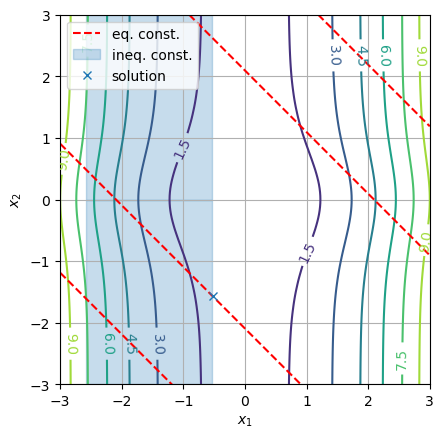

In [49]:
ax = plot_countours()
ax.plot(x[0], x[1], ls='none', marker='x', label='solution')
ax.legend(loc='upper left')
filename = 'nlp_contour_plot_sol'

plt.savefig(os.path.join(plot_dir, filename + '.pdf'))
plt.savefig(os.path.join(plot_dir, filename + '.png'), dpi=150)
plt.show()

## 2. Interior Point Method

### 2.1 Number of equations and unknowns

Relaxation of KKT conditions using the barrier parameter, $\tau$.

$$
\left\{\begin{array} { l } 
{ \nabla _ { x } \mathcal { L } = 0 } \\
{ g = 0 } \\
{ \nu \geq 0 } \\
{ h \leq 0 } \\
{ \nu _ { i } h _ { i } = 0 }
\end{array} \quad \Rightarrow \left\{\begin{array}{l}
\nabla_x \mathcal{L}=0 \\
g=0 \\
\nu_i h_i=-\tau
\end{array}\right.\right.
$$

This is a nonlinear system on which we can perform rootfinding.

Number of unknowns and equations:

| Equations     | Unknowns |
| ------------- | -------- |
| $\nabla_x f$  |  $n=2$   |
| $g=0$         |  $m=1$   |
| $\nu_i h_i$   |  $q=1$   |
| Total         |  4       |

In [50]:
x = MX.sym('x', 2)

In [51]:
# Problem to solve
f = x[0]**2 + tanh(x[1])**2
g = cos(x[0] + x[1]) + 0.5
h = sin(x[0]) + 0.5

In [52]:
lam = MX.sym('λ')  # Lagrangian multiplier
nu = MX.sym('ν')  # multiplier for the inequalities
tau = MX.sym('tau')  # barrier parameter
lagrangian_expr = f + lam * g + nu * h

### 2.2 Construct CasADi rootfinder

CasADi's rootfinder:

```
rf = rootfinder('rf','newton',{'x':...,'p': ...,'g':...})
```

In [53]:
G = {
    'x': vertcat(x, lam, nu),
    'p': tau,
    'g': vertcat(gradient(lagrangian_expr, x), g, nu * h + tau)
}

In [54]:
options = {'print_iteration': True}
rf = rootfinder('rf', 'newton', G, options)
rf

Function(rf:(x0[4],p)->(x[4]) Newton)

### 2.3 Perform rootfinding

In [55]:
x0 = vertcat(-0.5, -1.8)
lam0 = 0.1
nu0 = 0.1
tau = 0.01
x = vertcat(x0, lam0, nu0)
p = vertcat(tau)
x_sol_rf = rf(x, p)

 iter       res      step     alpha
    1  8.38e-01  1.82e+00  5.00e-01
    2  5.57e-01  2.37e-01  1.00e+00
    3  4.28e-02  2.31e-02  1.00e+00
    4  1.85e-04  4.02e-04  1.00e+00
    5  6.92e-08  1.35e-07  1.00e+00


In [56]:
x_sol_rf

DM([-0.5364485647933107, -1.557946537599885, 0.3436558523524212, 0.9019849948610718])

In [57]:
x_sol = x_sol_rf[:2]
assert np.all(np.isclose(x_sol, [[-0.5364485647933107], [-1.557946537599885]]))

### 2.4 Try adjusting barrier parameter

In [58]:
options = {'print_iteration': False}
rf = rootfinder('rf', 'newton', G, options)
for tau in [0.01, 0.001, 0.0001, 1e-5]:
    x = vertcat(x0, lam0, nu0)
    p = vertcat(tau)
    x_sol_rf = rf(x, p)
    print(f"tau = {tau}: x = [{x_sol_rf[0]}, {x_sol_rf[1]}], lam = {x_sol_rf[2]}, nu = {x_sol_rf[3]}")

tau = 0.01: x = [-0.5364485647933107, -1.557946537599885], lam = 0.3436558523524212, nu = 0.9019849948610718
tau = 0.001: x = [-0.5249177925112161, -1.56947730988198], lam = 0.3371545640514695, nu = 0.8757588336169068
tau = 0.0001: x = [-0.5237310364901067, -1.570664065903089], lam = 0.336490761784757, nu = 0.8730809346658457
tau = 1e-05: x = [-0.5236120052996532, -1.570783097093542], lam = 0.3364242374095784, nu = 0.8728125582016292
